In [1]:
dataset = 'kaggle.com/datasets/kumarajarshi/life-expectancy-who'

In [2]:
data_dir = './life-expectancy-who'

import os
os.listdir(data_dir)
!pip install skillsnetwork[regular]
from tqdm import tqdm
!pip install opendatasets --upgrade
import opendatasets as od
od.download(dataset)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

def warn(*args,**kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

Skipping, found downloaded files in "./life-expectancy-who" (use force=True to force download)


In [3]:
data = pd.read_csv('Life Expectancy Data.csv')
data.sample(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1260,Ireland,2005,Developed,78.7,78.0,0,13.31,973.681333,NaN,95,...,9.0,7.27,9.0,0.1,5886.827890,4159914.0,0.3,0.2,0.889,17.5
2177,Saint Lucia,2006,Developing,73.5,155.0,0,13.45,0.000000,85.0,0,...,85.0,6.37,85.0,0.1,NaN,NaN,4.3,4.4,0.694,12.4
212,Barbados,2011,Developing,74.9,14.0,0,8.51,173.982563,91.0,0,...,91.0,6.67,91.0,0.1,15534.157400,NaN,3.8,3.8,0.780,15.5
1376,Kenya,2001,Developing,51.9,434.0,77,1.63,3.847603,NaN,11304,...,77.0,4.62,8.0,16.9,41.776361,32321482.0,9.0,9.0,0.447,8.4
1626,Mali,2007,Developing,55.0,282.0,56,0.55,81.840501,74.0,2,...,76.0,6.97,74.0,1.7,595.636832,1367566.0,9.4,9.3,0.363,6.4


In [4]:
data.rename(columns={data.columns[3]:'Life expectancy',
                     data.columns[4]:'Adult mortality',
                     data.columns[5]:'Infant deaths',
                     data.columns[7]:'Health expenditure',
                     data.columns[9]:'Measles',
                     data.columns[10]:'BMI',
                     data.columns[11]:'Under-5 deaths',
                     data.columns[14]:'Diphtheria',
                     data.columns[15]:'HIV/AIDS',
                     data.columns[18]:'Thinness (1-19 years)',
                     data.columns[19]:'Thinness (5-9 years)'},
                    inplace=True)

data = data.drop('Country',axis=1)
first = data.pop('Status')
data.insert(len(data.columns),'Status',first)

null_count = data.isnull().sum()
print(null_count[null_count>0].sort_values(ascending=False),
      'Number of null entries:',null_count.sum())

for column in data:
    if data[column].isnull().sum() > 0:
        median = data[column].median()
        data[column].fillna(median,inplace=True)
null_count = data.isnull().sum()

print('Number of duplicated rows:',data.duplicated().sum())

data.sample(5)

Population                         652
Hepatitis B                        553
GDP                                448
Total expenditure                  226
Alcohol                            194
Income composition of resources    167
Schooling                          163
BMI                                 34
Thinness (1-19 years)               34
Thinness (5-9 years)                34
Polio                               19
Diphtheria                          19
Life expectancy                     10
Adult mortality                     10
dtype: int64 Number of null entries: 2563
Number of duplicated rows: 0


,Year,Life expectancy,Adult mortality,Infant deaths,Alcohol,Health expenditure,Hepatitis B,Measles,BMI,Under-5 deaths,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness (1-19 years),Thinness (5-9 years),Income composition of resources,Schooling,Status
309,2010,68.7,22.0,9,3.95,0.000000,91.0,0,49.3,12,...,5.44,91.0,0.2,1766.947595,1386542.0,1.2,1.1,0.643,13.8,Developing
2792,2001,49.6,46.0,110,4.09,0.000000,92.0,11847,16.4,173,...,3.28,87.0,12.5,1766.947595,1386542.0,8.2,8.1,0.677,12.3,Developing
694,2010,77.5,99.0,0,12.69,0.000000,99.0,0,63.6,0,...,7.43,99.0,0.1,1766.947595,1386542.0,1.9,2.0,0.677,12.3,Developed
518,2009,48.6,453.0,17,1.56,40.451569,42.0,11,19.8,25,...,3.58,42.0,7.3,449.961839,44423.0,9.1,9.1,0.345,6.4,Developing
998,2011,85.0,74.0,2,11.20,869.790735,88.0,1607,6.4,3,...,1.93,95.0,0.1,4681.327960,8274983.0,1.1,1.1,0.912,16.8,Developed


In [5]:
x_cols = data.columns[:-1]
y_col = 'Status'
x_data = data[x_cols]
y_data = data[y_col]

x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.25,random_state=42)

print(x_train.shape[0],'train samples')
print(x_test.shape[0],'test samples')

2203 train samples
735 test samples


In [6]:
poly = PolynomialFeatures(degree=2,include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)
x_poly = poly.transform(x_data)

print(x_train_poly.shape[1],'features')

230 features


In [7]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_train_s = pd.DataFrame(x_train,columns=x_data.columns)
x_test = ss.transform(x_test)
x_test_s = pd.DataFrame(x_test,columns=x_data.columns)

x_train_s.sample(5)

,Year,Life expectancy,Adult mortality,Infant deaths,Alcohol,Health expenditure,Hepatitis B,Measles,BMI,Under-5 deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness (1-19 years),Thinness (5-9 years),Income composition of resources,Schooling
599,0.747388,-0.089811,0.474170,-0.195210,0.533849,-0.275422,0.694883,-0.187691,0.567377,-0.216561,0.696572,-0.547768,0.696904,-0.320205,0.385363,-0.191454,-0.571593,-0.526321,0.655578,0.725715
670,-0.124004,0.635735,-1.199979,-0.258426,0.157849,-0.362579,0.475441,-0.184396,0.647226,-0.262565,0.524557,1.020949,0.528594,-0.320205,-0.460323,-0.194701,-0.457116,-0.459041,0.342809,0.260764
619,1.618780,0.593674,-0.185831,0.120869,-0.201525,-0.366781,0.563218,-0.180341,0.876795,0.046317,0.653568,-0.067166,0.570672,-0.320205,0.168428,-0.142663,-0.480012,-0.503895,0.596003,0.973688
2181,-0.777549,1.087887,-0.757295,-0.258426,-0.791104,-0.262634,0.475441,-0.190310,-0.430747,-0.262565,0.524557,-1.142799,0.528594,-0.320205,-0.284871,-0.166945,-0.617383,-0.638455,0.923666,0.198770
1468,-0.559701,-1.646054,0.908805,0.238269,-1.133852,-0.364868,0.387664,-0.013997,-1.154387,0.486638,-1.582630,0.513301,-1.575277,-0.030564,-0.489948,0.078585,1.626357,1.559368,-1.767142,-2.652929


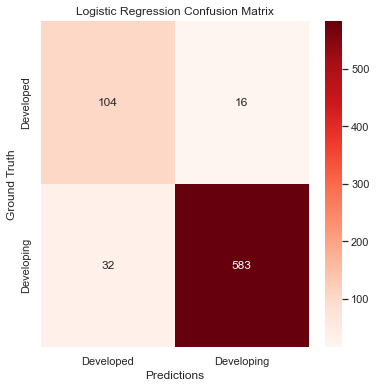

In [8]:
# (UNREGULARISED) LOGISTIC REGRESSION
lr = LogisticRegression()
lr.fit(x_train_s,y_train)
y_pred_lr = lr.predict(x_test_s)
cm_lr = confusion_matrix(y_test,y_pred_lr)
plt.figure(figsize=(6,6))
sns.heatmap(cm_lr,annot=True,fmt='d',cmap='Reds',
            xticklabels=['Developed','Developing'], 
            yticklabels=['Developed','Developing'])
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title('Logistic Regression Confusion Matrix')

plt.show()

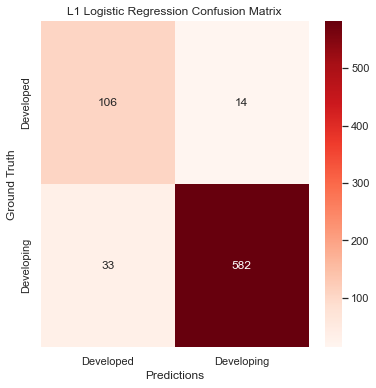

In [9]:
# L1-REGULARISED LOGISTIC REGRESSION
lr_l1 = LogisticRegressionCV(Cs=10,cv=4,penalty='l1',solver='liblinear')
lr_l1.fit(x_train_s,y_train)
y_pred_lr_l1 = lr_l1.predict(x_test_s)
cm_lr = confusion_matrix(y_test,y_pred_lr_l1)
plt.figure(figsize=(6,6))
sns.heatmap(cm_lr,annot=True,fmt='d',cmap='Reds', 
            xticklabels=['Developed','Developing'], 
            yticklabels=['Developed','Developing'])
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title('L1 Logistic Regression Confusion Matrix')

plt.show()

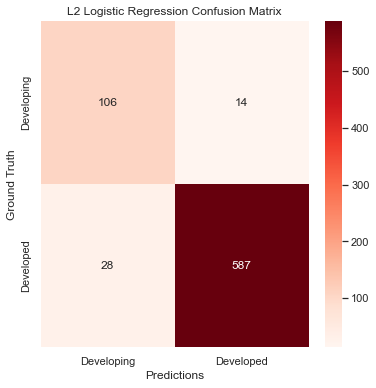

In [10]:
# L2-REGULARISED LOGISTIC REGRESSION
lr_l2 = LogisticRegressionCV(Cs=10,cv=4,penalty='l2',solver='liblinear')
lr_l2.fit(x_train_s,y_train)
y_pred_lr_l2 = lr_l2.predict(x_test_s)
cm_lr = confusion_matrix(y_test,y_pred_lr_l2)
plt.figure(figsize=(6,6))
sns.heatmap(cm_lr,annot=True,fmt='d',cmap='Reds', 
            xticklabels=['Developing','Developed'], 
            yticklabels=['Developing','Developed'])
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title('L2 Logistic Regression Confusion Matrix')

plt.show()

In [11]:
coef = lr.coef_
coef_df = pd.DataFrame({'Feature':x_train_s.columns,'Coefficient':coef[0]}).sort_values(by='Coefficient',ascending=False)

display(coef_df)

,Feature,Coefficient
16,Thinness (1-19 years),1.466232
15,Population,0.595852
2,Adult mortality,0.590236
13,HIV/AIDS,0.562609
0,Year,0.382166
5,Health expenditure,0.291016
3,Infant deaths,0.273191
17,Thinness (5-9 years),0.269174
19,Schooling,0.234137
9,Under-5 deaths,0.175399


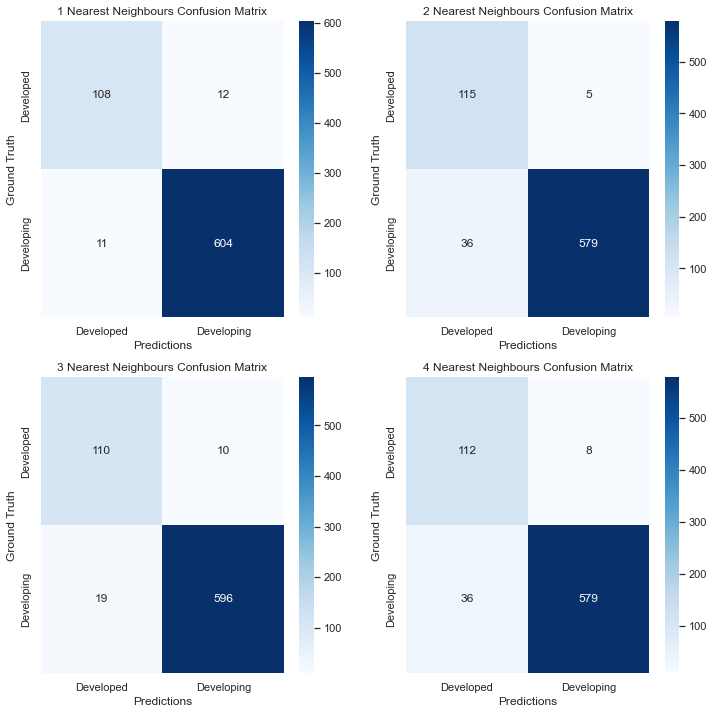

In [12]:
# K-NEAREST NEIGHBOURS
neighbors = [1,2,3,4]
errors = []
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12))
for i, neighbor in enumerate(neighbors):
    row = i // 2
    col = i % 2
    knc = KNeighborsClassifier(n_neighbors=neighbor)
    knc.fit(x_train,y_train)
    y_pred_knc = knc.predict(x_test)   
    cm_knc = confusion_matrix(y_test,y_pred_knc)
    sns.heatmap(cm_knc, annot=True,fmt='d',cmap='Blues',ax=ax[row,col], 
                xticklabels=['Developed','Developing'], 
                yticklabels=['Developed','Developing'])
    ax[row,col].set_title(f'{neighbor} Nearest Neighbours Confusion Matrix')
    ax[row,col].set_xlabel('Predictions')
    ax[row,col].set_ylabel('Ground Truth')

plt.show()

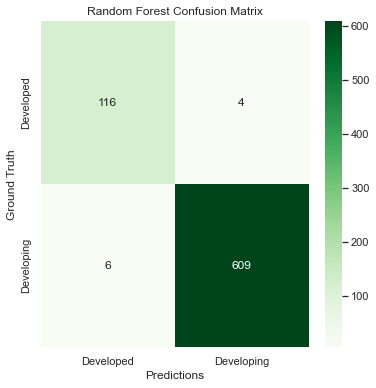

In [13]:
# RANDOM FOREST
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
y_pred_rfc = rfc.predict(x_test)
cm_rfc = confusion_matrix(y_test,y_pred_rfc)
plt.figure(figsize=(6,6))
sns.heatmap(cm_rfc, annot=True,fmt='d',cmap='Greens', 
            xticklabels=['Developed','Developing'], 
            yticklabels=['Developed','Developing'])
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title('Random Forest Confusion Matrix')

plt.show()

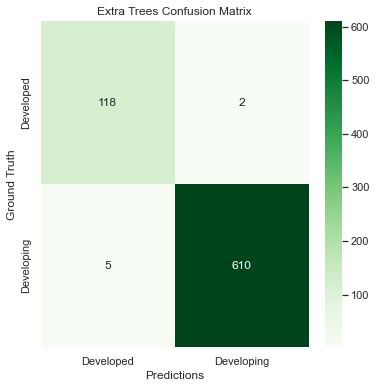

In [14]:
# EXTRA TREES
etc = ExtraTreesClassifier()
etc.fit(x_train,y_train)
y_pred_etc = etc.predict(x_test)
cm_etc = confusion_matrix(y_test,y_pred_etc)
plt.figure(figsize=(6,6))
sns.heatmap(cm_etc,annot=True,fmt='d',cmap='Greens', 
            xticklabels=['Developed','Developing'], 
            yticklabels=['Developed','Developing'])
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title('Extra Trees Confusion Matrix')

plt.show()

In [15]:
fi = rfc.feature_importances_
fi_df = pd.DataFrame({'Feature':x_train_s.columns,'Importance':fi}).sort_values(by='Importance',ascending=False)

display(fi_df)

,Feature,Importance
4,Alcohol,0.180374
18,Income composition of resources,0.143340
1,Life expectancy,0.140469
16,Thinness (1-19 years),0.084069
19,Schooling,0.078818
17,Thinness (5-9 years),0.071358
2,Adult mortality,0.035612
14,GDP,0.033335
8,BMI,0.033299
5,Health expenditure,0.025173


In [16]:
target_names = ['developed','developing']
print(classification_report(y_test,y_pred_etc,target_names=target_names))

              precision    recall  f1-score   support

   developed       0.96      0.98      0.97       120
  developing       1.00      0.99      0.99       615

    accuracy                           0.99       735
   macro avg       0.98      0.99      0.98       735
weighted avg       0.99      0.99      0.99       735

